1.Current Feature
========================

## Time Feature 
AbsMax
AbsMean
P2P
Skewness
Kurtosis
RMS
CrestFactor
ShapeFactor
ImpulseFactor

## Phase Feature 
Shift
RS-Phase Shift
ST-Phase Shift
TR-Phase Shift
Phase Level Shift
## Frequency Feature 
FFT
Frequency IDX(1x~4x)



2.Vibration Feature
=============================================

AbsMax
AbsMean
P2P
Skewness
Kurtosis
RMS
CrestFactor
ShapeFactor
ImpulseFactor
## Vibration Feature
FFT
Fequency IDX(1x~4x)

In [1]:
import glob
import numpy as np
import pandas as pd

import scipy
import sklearn
from sklearn.metrics import accuracy_score, classification_report
from scipy.stats import skew, kurtosis

In [2]:
class Extract_Time_Features:    
    def __init__(self, rawTimeData):
        self._TimeFeatures = []
        self._rawTimeData = rawTimeData

    def AbsMax(self):
        self._absmax = np.abs(self._rawTimeData).max(axis=1)
        return self._absmax
    
    def AbsMean(self):
        self._absmean = np.abs(self._rawTimeData).mean(axis=1)
        return self._absmean
    
    def P2P(self):
        self._peak2peak = np.max(self._rawTimeData,axis=1) - np.min(self._rawTimeData,axis=1)
        return self._peak2peak 
    
    def Skewness(self):
        self._skewness = skew(self._rawTimeData, axis=1, nan_policy='raise')
        return self._skewness
    
    def Kurtosis(self):
        self._kurtosis = kurtosis(self._rawTimeData, axis=1, fisher=False)
        return self._kurtosis

    def RMS(self):
        self._rms = np.sqrt(np.sum(self._rawTimeData**2, axis=1) / self._rawTimeData.shape[1])
        return self._rms
    
    def CrestFactor(self):
        self._cresfactor = self.P2P() / self.RMS()
        return self._cresfactor
    
    def ShapeFactor(self):
        self._shapefactor = self.RMS() / self.AbsMean()
        return self._shapefactor
    
    def ImpulseFactor(self):
        self._impulsefactor = self.AbsMax() / self.AbsMean()
        return self._impulsefactor

    def Features(self):
        # Time-domain Features #
        self._TimeFeatures.append(self.AbsMax())        # Feature 1: Absolute Maximum 
        self._TimeFeatures.append(self.AbsMean())       # Feature 2: Absolute Mean
        self._TimeFeatures.append(self.P2P())           # Feature 3: Peak-to-Peak
        self._TimeFeatures.append(self.RMS())           # Feature 4: Root-mean-square
        self._TimeFeatures.append(self.Skewness())      # Feature 5: Skewness
        self._TimeFeatures.append(self.Kurtosis())      # Feature 6: Kurtosis
        self._TimeFeatures.append(self.CrestFactor())   # Feature 7: Crest Factor
        self._TimeFeatures.append(self.ShapeFactor())   # Feature 8: Shape Factor
        self._TimeFeatures.append(self.ImpulseFactor()) # Feature 9: Impulse Factor
                
        return np.asarray(self._TimeFeatures)

In [3]:
class Extract_Freq_Features:    
    def __init__(self, rawTimeData, rpm, Fs):
        self._FreqFeatures = []
        # Remove bias (subtract mean by each channel) #
        self._rawTimeData = rawTimeData - np.expand_dims(np.mean(rawTimeData,axis=1),axis=1) # Raw time data
        
        self._Fs = Fs                    # Sampling frequency [Hz]
        self._rpm = rpm/60               # RPM for every second [Hz]
       
    def FFT(self):
        # Perform FFT #
        _N = self._rawTimeData.shape[1]
        _dt = 1/self._Fs
        _yf_temp = np.fft.fft(self._rawTimeData)
        self._yf = np.abs(_yf_temp[:,:int(_N/2)]) / (_N/2)
        self._xf = np.fft.fftfreq(_N, d=_dt)[:int(_N/2)]
        
        return self._xf, self._yf
    
    def Freq_IDX(self):
        _xf,_yf = self.FFT()
        
        # Motor #
        # find frequency index of 1x #
        self._Freq_1x = self._rpm
        self._1x_idx_Temp = abs(_xf - self._Freq_1x).argmin()
        self._1x_idx_Temp = self._1x_idx_Temp - 2 + np.argmax(self._yf[0][np.arange(self._1x_idx_Temp-2, self._1x_idx_Temp+3)])
        self._1x_idx = np.arange(self._1x_idx_Temp-1, self._1x_idx_Temp+2)

        # find frequency index of 2x #
        self._Freq_2x = self._xf[self._1x_idx[1]] * 2
        self._2x_idx_Temp = abs(_xf - self._Freq_2x).argmin()
        self._2x_idx_Temp = self._2x_idx_Temp - 5 + np.argmax(self._yf[0][np.arange(self._2x_idx_Temp-5, self._2x_idx_Temp+6)])
        self._2x_idx = np.arange(self._2x_idx_Temp-1, self._2x_idx_Temp+2)
        
        # find frequency index of 3x #
        self._Freq_3x = self._xf[self._1x_idx[1]] * 3
        self._3x_idx_Temp = abs(_xf - self._Freq_3x).argmin()
        self._3x_idx_Temp = self._3x_idx_Temp - 5 + np.argmax(self._yf[0][np.arange(self._3x_idx_Temp-5, self._3x_idx_Temp+6)])
        self._3x_idx = np.arange(self._3x_idx_Temp-1, self._3x_idx_Temp+2)
        
        # find frequency index of 4x #
        self._Freq_4x = self._xf[self._1x_idx[1]]  * 4
        self._4x_idx_Temp = abs(_xf - self._Freq_4x).argmin()
        self._4x_idx_Temp = self._4x_idx_Temp - 5 + np.argmax(self._yf[0][np.arange(self._4x_idx_Temp-5, self._4x_idx_Temp+6)])
        self._4x_idx = np.arange(self._4x_idx_Temp-1, self._4x_idx_Temp+2)
        
        # Belt #
        # find frequency index of 1x #
        self._Freq_1x_B = self._Freq_1x - 5
        self._1x_idx_B_Temp = abs(_xf - self._Freq_1x_B).argmin()
        self._1x_idx_B_Temp = self._1x_idx_B_Temp - 2 + np.argmax(self._yf[0][np.arange(self._1x_idx_B_Temp-2, self._1x_idx_B_Temp+3)])
        self._1x_idx_B = np.arange(self._1x_idx_B_Temp-1, self._1x_idx_B_Temp+2)

        # find frequency index of 2x #
        self._Freq_2x_B = self._xf[self._1x_idx_B[1]] * 2
        self._2x_idx_B_Temp = abs(_xf - self._Freq_2x_B).argmin()
        self._2x_idx_B_Temp = self._2x_idx_B_Temp - 5 + np.argmax(self._yf[0][np.arange(self._2x_idx_B_Temp-5, self._2x_idx_B_Temp+6)])
        self._2x_idx_B = np.arange(self._2x_idx_B_Temp-1, self._2x_idx_B_Temp+2)
        
        # find frequency index of 3x #
        self._Freq_3x_B = self._xf[self._1x_idx_B[1]] * 3
        self._3x_idx_B_Temp = abs(_xf - self._Freq_3x_B).argmin()
        self._3x_idx_B_Temp = self._3x_idx_B_Temp - 5 + np.argmax(self._yf[0][np.arange(self._3x_idx_B_Temp-5, self._3x_idx_B_Temp+6)])
        self._3x_idx_B = np.arange(self._3x_idx_B_Temp-1, self._3x_idx_B_Temp+2)
        
        # find frequency index of 4x #
        self._Freq_4x_B = self._xf[self._1x_idx_B[1]] * 4
        self._4x_idx_B_Temp = abs(_xf - self._Freq_4x_B).argmin()
        self._4x_idx_B_Temp = self._4x_idx_B_Temp - 5 + np.argmax(self._yf[0][np.arange(self._4x_idx_B_Temp-5, self._4x_idx_B_Temp+6)])
        self._4x_idx_B = np.arange(self._4x_idx_B_Temp-1, self._4x_idx_B_Temp+2)
        
        
        return (self._1x_idx, self._2x_idx, self._3x_idx, self._4x_idx,
                self._1x_idx_B, self._2x_idx_B, self._3x_idx_B, self._4x_idx_B)

    def Features(self):
        _xf, _yf = self.FFT()
        idx = self.Freq_IDX()
                
        # Freq-domain Features #
        self._1x_Feature = np.sum(_yf[:, idx[0]], axis=1) 
        self._2x_Feature = np.sum(_yf[:, idx[1]], axis=1) 
        self._3x_Feature = np.sum(_yf[:, idx[2]], axis=1) 
        self._4x_Feature = np.sum(_yf[:, idx[3]], axis=1)
        self._1x_Feature_B = np.sum(_yf[:, idx[4]], axis=1) 
        self._2x_Feature_B = np.sum(_yf[:, idx[5]], axis=1) 
        self._3x_Feature_B = np.sum(_yf[:, idx[6]], axis=1) 
        self._4x_Feature_B = np.sum(_yf[:, idx[7]], axis=1) 
                
        self._FreqFeatures.append(self._1x_Feature)
        self._FreqFeatures.append(self._2x_Feature)
        self._FreqFeatures.append(self._3x_Feature)
        self._FreqFeatures.append(self._4x_Feature)
        self._FreqFeatures.append(self._1x_Feature_B)
        self._FreqFeatures.append(self._2x_Feature_B)
        self._FreqFeatures.append(self._3x_Feature_B)
        self._FreqFeatures.append(self._4x_Feature_B)
        
        return np.asarray(self._FreqFeatures)

In [4]:
def validation(filename):
    vib = pd.read_csv(filename, header=None, skiprows=9)
    vib = np.asarray(vib)[:,1:-1].transpose()

    date = pd.read_csv(filename, header=None, skiprows=0, nrows=1)
    date = date[1]

    meta = pd.read_csv(filename, header=None, skiprows=4, nrows=1)
    rpm = int(meta[2])

    fs = pd.read_csv(filename, header=None, skiprows=6, nrows=1)
    Fs = int(fs[1])

    TimeFeatureExtractor = Extract_Time_Features(vib)
    features_time = TimeFeatureExtractor.Features().flatten()

    FreqFeatureExtractor = Extract_Freq_Features(vib, rpm, Fs)
    features_freq = FreqFeatureExtractor.Features().flatten()

    y = pd.read_csv(filename, header=None, skiprows=3, nrows=1)
    y = y[1]
    
    vib_dataset = np.concatenate((date, features_time, features_freq, meta[3], y))

    return vib_dataset

# Vibration Training

In [9]:
folder_path = "C:/Users/qhrrl/CodeExamples/3.Paper/0.Dataset"

datapath = glob.glob(folder_path + "/vib_training_2.2" + '**/**/*.csv', recursive=True)

In [10]:
len(datapath)

196032

In [11]:
vib_dataset_list = []

for file in datapath:
    dataset = validation(file)
    vib_dataset_list.append(dataset)

In [12]:
vib_dataset = pd.DataFrame(vib_dataset_list)

In [13]:
vib_dataset.columns = [ 'Date',
    'AbsMax', 'AbsMean', 'P2P', 'RMS', 'Skewness', 'Kurtosis', 'Crest', 
    'Shape', 'Impulse','1x', '2x', '3x', '4x', '1xB', '2xB', '3xB', '4xB',
               'WATT', 'LABEL']

In [14]:
vib_dataset.head(3)

,Date,AbsMax,AbsMean,P2P,RMS,Skewness,Kurtosis,Crest,Shape,Impulse,1x,2x,3x,4x,1xB,2xB,3xB,4xB,WATT,LABEL
0,2020-11-25 15:47:09,0.031503,0.002348,0.041003,0.002963,-0.252712,4.821787,13.839364,1.261929,13.418192,0.000168,0.000179,0.000778,0.000514,0.000215,0.000408,0.000186,0.001045,2.2,0
1,2020-11-25 15:47:12,0.050405,0.002355,0.061181,0.003016,-0.658560,11.017264,20.288108,1.280328,21.400306,0.000550,0.000262,0.000381,0.000484,0.000168,0.000309,0.000311,0.001069,2.2,0
2,2020-11-25 15:47:15,0.026258,0.002471,0.036879,0.003133,-0.281960,4.263064,11.769368,1.268231,10.627622,0.000262,0.000239,0.000797,0.000665,0.000154,0.000403,0.000160,0.001294,2.2,0


In [15]:
len(vib_dataset)

196032

<AxesSubplot:xlabel='LABEL', ylabel='count'>

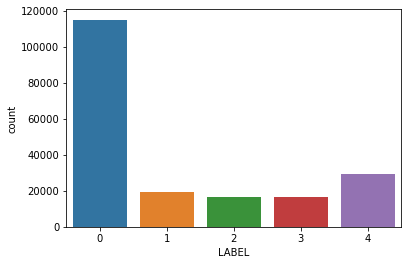

In [16]:
import seaborn as sns

sns.countplot(x='LABEL', data=vib_dataset)

In [17]:
vib_dataset.to_csv('vib_training_all.csv', index=False)

# Vibration validation

In [18]:
datapath = glob.glob(folder_path + "/vib_validation_2.2" + '**/**/*.csv', recursive=True)

In [19]:
len(datapath)

24522

In [20]:
vib_dataset_list_val = []

for file in datapath:
    val_dataset = validation(file)
    vib_dataset_list_val.append(val_dataset)

In [21]:
pd_vib_dataset = pd.DataFrame(vib_dataset_list_val)
pd_vib_dataset.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,2020-11-25 14:11:30,0.045103,0.002272,0.056123,0.002949,-1.052663,14.286923,19.030214,1.297919,19.849866,0.000467,0.000282,0.000256,0.000372,0.000290,0.000294,0.000198,0.000170,2.2,0
1,2020-11-25 14:11:33,0.034806,0.002352,0.044912,0.003002,-0.518928,6.886467,14.960807,1.276331,14.798102,0.000555,0.000243,0.000332,0.000374,0.000237,0.000355,0.000166,0.000260,2.2,0
2,2020-11-25 14:11:36,0.020148,0.002250,0.030580,0.002812,-0.095521,3.272939,10.873323,1.249954,8.954917,0.000608,0.000204,0.000195,0.000395,0.000230,0.000558,0.000167,0.000324,2.2,0


In [22]:
pd_vib_dataset.columns = [ 'Date',
    'AbsMax', 'AbsMean', 'P2P', 'RMS', 'Skewness', 'Kurtosis', 'Crest', 
    'Shape', 'Impulse','1x', '2x', '3x', '4x', '1xB', '2xB', '3xB', '4xB',
               'WATT', 'LABEL']

In [23]:
pd_vib_dataset.head(3)

,Date,AbsMax,AbsMean,P2P,RMS,Skewness,Kurtosis,Crest,Shape,Impulse,1x,2x,3x,4x,1xB,2xB,3xB,4xB,WATT,LABEL
0,2020-11-25 14:11:30,0.045103,0.002272,0.056123,0.002949,-1.052663,14.286923,19.030214,1.297919,19.849866,0.000467,0.000282,0.000256,0.000372,0.000290,0.000294,0.000198,0.000170,2.2,0
1,2020-11-25 14:11:33,0.034806,0.002352,0.044912,0.003002,-0.518928,6.886467,14.960807,1.276331,14.798102,0.000555,0.000243,0.000332,0.000374,0.000237,0.000355,0.000166,0.000260,2.2,0
2,2020-11-25 14:11:36,0.020148,0.002250,0.030580,0.002812,-0.095521,3.272939,10.873323,1.249954,8.954917,0.000608,0.000204,0.000195,0.000395,0.000230,0.000558,0.000167,0.000324,2.2,0


In [24]:
len(pd_vib_dataset)

24522

<AxesSubplot:xlabel='LABEL', ylabel='count'>

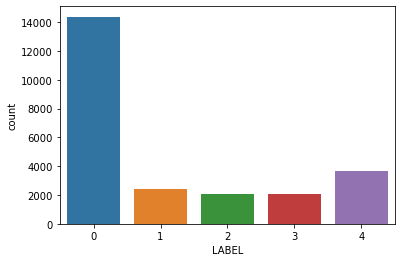

In [25]:
import seaborn as sns

sns.countplot(x='LABEL', data=pd_vib_dataset)

In [26]:
pd_vib_dataset.to_csv('vib_validation_all.csv', index=False)